The goal of this notebook is to implement the DIRT-T solver.

In [1]:
import torch
from torch import nn

from salad import models

model = torch.load('log/noise4/20180803-011234_MultidomainBCESolver/20180803-011234-checkpoint-ep100.pth')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'salad.models.fan.ConditionalModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'salad.models.fan.ConditionalBatchNorm' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attrib

In [2]:
import h5py
import torch
from torch import nn

import torch
import torch.nn.functional as F

In [3]:
from salad.datasets import load_dataset
from torchvision import transforms, datasets

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.188508,    0.19058265,  0.18615675))
])
svhn = datasets.SVHN('/tmp/data', split='train', download=True, transform=transform)

loader = torch.utils.data.DataLoader(
    svhn, batch_size=256,
    shuffle=True)

Using downloaded and verified file: /tmp/data/train_32x32.mat


In [29]:
mean = torch.tensor([0.5, 0.5, 0.5]).view(1,3,1,1)
std  = torch.tensor([0.188508,    0.19058265,  0.18615675]).view(1,3,1,1)

dstd = lambda x : x.cpu() * std + mean

In [99]:
kl = KLDivWithLogits()
ce = nn.CrossEntropyLoss()

print(ce(p, y))
print(kl(p, p*-1))

tensor(0.1215, device='cuda:0')
tensor(10.6916, device='cuda:0')


tensor(0.9648, device='cuda:0')
loss:  tensor(1.00000e-02 *
       3.8945, device='cuda:0')
acc:  tensor(0.9805, device='cuda:0')
tensor(0.8398, device='cuda:0')


(0, 0.1)

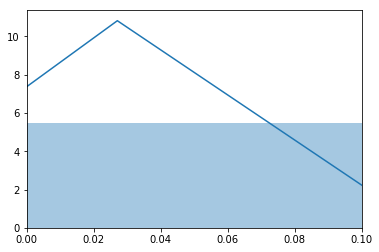

In [103]:
def normalize_perturbation(d):
    d_ = d.view(d.size()[0], -1)
    eps = torch.tensor(1e-12).type(d.type())
    output = d / torch.sqrt(torch.max((d_**2).sum(dim = -1), eps)[0] )
    return output

def _pertub(x, p, model, radius=1):
    loss_func_nll = KLDivWithLogits()
    
    eps = (torch.randn(size=x.size())).type(x.type())

    eps = 1e-6 * normalize_perturbation(eps)
    eps.requires_grad_(True)

    _, eps_p = model(x + eps)

    loss  = loss_func_nll(eps_p, p.detach())
    print('loss: ', loss)
    print('acc: ', (p.max(dim=-1)[1] == eps_p.max(dim=-1)[1]).float().mean())
    loss.backward()
    eps_adv = eps.grad

    eps_adv = normalize_perturbation(eps_adv)
    x_adv = x + radius * eps_adv

    return x_adv.detach()

for x, y in loader:
    y = y.cuda()
    x = x.cuda()
    
    _, p = model(x.cuda())
    p = p.detach()
    print((p.max(dim=-1)[1] == y).float().mean())
    
    x_adv = _pertub(x, p, model, radius=3.5)
    _, p_adv = model(x_adv)
    p_adv = p_adv.detach()
    print((p_adv.max(dim=-1)[1] == y).float().mean())
    
    x_adv = x_adv.cpu()
    x = x.cpu()
    
    break

import seaborn as sns
sns.distplot(abs(x_adv - x).mean(dim=1).view(-1))

plt.xlim([0,.1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


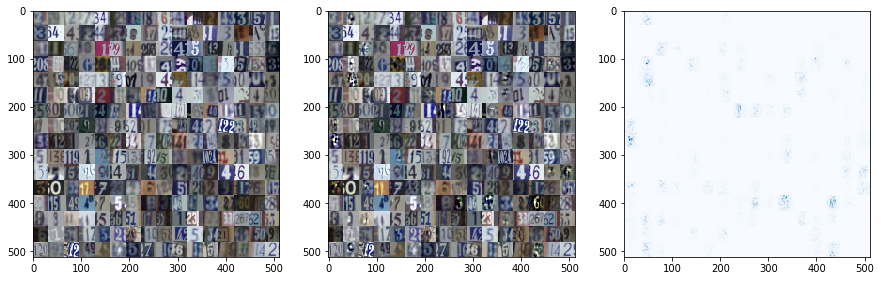

In [104]:
from salad.utils import panelize
import matplotlib.pyplot as plt
%matplotlib inline

_, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(panelize(dstd(x).cpu().numpy()))
ax2.imshow(panelize(dstd(x_adv).numpy()))
ax3.imshow(panelize(abs(x_adv - x).mean(dim=1, keepdim=True).numpy()).squeeze(), cmap='Blues')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(42, device='cuda:0')


tensor([ 2,  9,  6,  2,  8,  4,  4,  7,  7,  6,  3,  5,  3,  0,
         1,  0,  3,  3,  6,  5,  3,  2,  9,  3,  7,  2,  2,  1,
         0,  1,  9,  9,  1,  7,  9,  2,  3,  6,  1,  0,  9,  3], device='cuda:0')

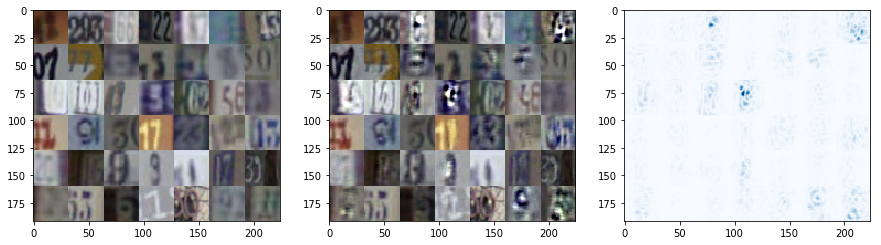

In [105]:
idc = torch.ne(p.max(dim=-1)[1], p_adv.max(dim=-1)[1])

print(idc.sum())

_, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(panelize(dstd(x[idc]).cpu().numpy()))
ax2.imshow(panelize(dstd(x_adv[idc]).numpy()))
ax3.imshow(panelize(abs(x_adv[idc] - x[idc]).mean(dim=1, keepdim=True).numpy()).squeeze(), cmap='Blues')

y[idc]

In [7]:
idc = torch.eq(p.max(dim=-1)[1], p_adv.max(dim=-1)[1])

print(idc.sum())

_, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(panelize(dstd(x[idc]).cpu().numpy()))
ax2.imshow(panelize(dstd(x_adv[idc]).numpy()))
ax3.imshow(panelize(abs(x_adv[idc] - x[idc]).mean(dim=1, keepdim=True).numpy()).squeeze(), cmap='Blues')

y[idc]

NameError: name 'p_adv' is not defined

In [6]:
from salad.layers.vat import VATLoss

loss = VATLoss(model, radius=3.5)

for x, y in loader:
    y = y.cuda()
    x = x.cuda()
    
    _, p = model(x.cuda())
    p = p.detach()
    print((p.max(dim=-1)[1] == y).float().mean())
    
    l = loss(x, p)
    
    break
    
l

tensor(0.9609, device='cuda:0')


tensor(0.8093, device='cuda:0')